<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Manipulate-Hamiltonian-into-blocks" data-toc-modified-id="Manipulate-Hamiltonian-into-blocks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Manipulate Hamiltonian into blocks</a></span></li><li><span><a href="#Feature-computation" data-toc-modified-id="Feature-computation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature computation</a></span></li><li><span><a href="#Feature-Preprocessing" data-toc-modified-id="Feature-Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature Preprocessing</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#DataLoader" data-toc-modified-id="DataLoader-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>DataLoader</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Tests" data-toc-modified-id="Tests-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Tests</a></span><ul class="toc-item"><li><span><a href="#set-up-wigner-d-rotations-matrices" data-toc-modified-id="set-up-wigner-d-rotations-matrices-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>set up wigner-d rotations matrices</a></span></li><li><span><a href="#block-wise-rotations" data-toc-modified-id="block-wise-rotations-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>block wise rotations</a></span></li><li><span><a href="#Rotate-matrix" data-toc-modified-id="Rotate-matrix-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>Rotate matrix</a></span></li><li><span><a href="#Eigenvalue-tests" data-toc-modified-id="Eigenvalue-tests-9.4"><span class="toc-item-num">9.4&nbsp;&nbsp;</span>Eigenvalue tests</a></span></li><li><span><a href="#check-decoupling-of-blocks" data-toc-modified-id="check-decoupling-of-blocks-9.5"><span class="toc-item-num">9.5&nbsp;&nbsp;</span>check decoupling of blocks</a></span></li><li><span><a href="#check-feature-rotations" data-toc-modified-id="check-feature-rotations-9.6"><span class="toc-item-num">9.6&nbsp;&nbsp;</span>check feature rotations</a></span></li></ul></li><li><span><a href="#need-to-modify-samples-for-features-to-start-from-1" data-toc-modified-id="need-to-modify-samples-for-features-to-start-from-1-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>need to modify samples for features to start from 1</a></span></li></ul></div>

In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import numpy as np
import torch
import json
import ase.io
from itertools import product
import matplotlib.pyplot as plt
# from rascal.representations import SphericalExpansion
import copy
from tqdm import tqdm
from ase.units import Hartree

from torch_hamiltonian_utils.torch_cg import ClebschGordanReal
from torch_hamiltonian_utils.torch_ham import fix_pyscf_l1, dense_to_blocks, blocks_to_dense, couple_blocks, decouple_blocks, hamiltonian_features
from torch_hamiltonian_utils.torch_builder import TensorBuilder

import equistore
from equistore import Labels, TensorBlock, TensorMap
from equistore_utils.librascal import  RascalSphericalExpansion, RascalPairExpansion
from equistore_utils.acdc_mini import acdc_standardize_keys, cg_increment, cg_combine
from equistore_utils.model_hamiltonian import get_feat_keys, get_feat_keys_from_uncoupled 

import importlib
torch.set_default_dtype(torch.float64)

In [2]:
def get_feat_keys_from_uncoupled(block_keys, sigma=None, order_nu=None):
    """Map UNCOUPLED block keys to corresponding feature key. take as extra input the sigma, nu value if required.
    sigma=0 returns all possible sigma values at given 'nu'"""
    blocktype, species1, n1, l1, species2, n2, l2 = block_keys
    feat_blocktype = blocktype
    keys_L=[]
    for L in range(abs(l1-l2), l1+l2+1):
        if sigma is None:
            z = (l1+l2+L)%2
            inv_sigma = 1 - 2*z
        elif abs(sigma)==1:
            inv_sigma = sigma
        else: 
            raise("Please check sigma value, it should be +1 or -1")
        
        #if blocktype == 1 and n1 == n2 and l1 == l2:
        #    feat_blocktype = inv_sigma
                 
        if inv_sigma == -1 and blocktype == 0 and n1 == n2 and l1 == l2:
            continue     
        
        keys_L.append([(order_nu, inv_sigma, L, species1, species2, feat_blocktype)])
    #     feat= (blocktype, L,sigma,species1, species2)
    feat = Labels(["order_nu", "inversion_sigma", "spherical_harmonics_l", "species_center", "species_neighbor", "block_type"], np.asarray(keys_L, dtype=np.int32).reshape(-1,6))
    return feat

In [3]:
def lowdin_orthogonalize(fock, s):
    """
    lowdin orthogonalization of a fock matrix computing the square root of the overlap matrix
    """
    eva, eve = np.linalg.eigh(s)
    sm12 = eve @ np.diag(1.0/np.sqrt(eva)) @ eve.T
    return sm12 @ fock @ sm12

In [4]:
frames = ase.io.read("data/ethene/coords_ethene_1000.xyz",":200")
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50 

jorbs = json.load(open('data/ethene/orbs-sto3g.json', "r"))
orbs = {}
zdic = {"O" : 8, "H":1, "C":6}
for k in jorbs:
    orbs[zdic[k]] = jorbs[k]

focks = np.load("data/ethene/ethene-sto3g-fock-ortho.npy", allow_pickle=True)[:len(frames)]
#overlaps = np.load("data/ethene/ethene-sto3g-overlap.npy", allow_pickle=True)[:len(frames)]

## Hyperparameters for feature calculation

In [5]:
rascal_hypers = {
    "interaction_cutoff": 4.0,
    "cutoff_smooth_width": 0.5,
    "max_radial": 6,
    "max_angular": 4,
    "gaussian_sigma_constant" : 0.3,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
}
lmax = rascal_hypers["max_angular"]
cg = ClebschGordanReal(lmax)

## Feature calculation

In [6]:
spex = RascalSphericalExpansion(rascal_hypers)
rhoi = spex.compute(frames)

In [7]:
pairs = RascalPairExpansion(rascal_hypers)
gij = pairs.compute(frames)

In [8]:
rho1i = acdc_standardize_keys(rhoi)
rho1i = rho1i.keys_to_properties(['species_neighbor'])
gij =  acdc_standardize_keys(gij)

In [9]:
rho2i = cg_increment(rho1i, rho1i, lcut=lmax, other_keys_match=["species_center"], clebsch_gordan=cg)

In [10]:
#rho3i = cg_increment(rho2i, rho1i, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

In [11]:
rho1ij = cg_increment(rho1i, gij, lcut=lmax, other_keys_match=["species_center"], clebsch_gordan=cg)

In [12]:
#rho2ij = cg_increment(rho2i, gij, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

In [13]:
features = hamiltonian_features(rho2i, rho1ij)

In [14]:
features

TensorMap with 63 blocks
keys: ['order_nu' 'inversion_sigma' 'spherical_harmonics_l' 'species_center' 'species_neighbor' 'block_type']
           2             1                    0                   1                1              0
           2             1                    1                   1                1              0
           2             1                    2                   1                1              0
        ...
           2            -1                    3                   6                6             -1
           2            -1                    4                   6                6              1
           2            -1                    4                   6                6             -1

In [15]:
from equistore.io import save
save("features-ethene-sto3g.npz", features)

## Feature Preprocessing

In [16]:
def normalize_feats(feat, all_blocks=True): 
    all_norm = 0
    normalized_blocks=[]
    for block_idx, block in feat: 
        block_norm = np.linalg.norm(block.values)
#         print(block_idx, block_norm)
        all_norm = block_norm**2 * len(block.samples) 
    
        newblock = TensorBlock(
                        values=block.values/np.sqrt(all_norm ),
                        samples=block.samples,
                        components=block.components,
                        properties= block.properties)                    
        normalized_blocks.append(newblock) 
        
    norm_feat = TensorMap(feat.keys, normalized_blocks)
    raise Exception ("Dont do it!")
    return norm_feat

In [22]:
#norm_feat = normalize_feats(features)

In [23]:
# from equistore.io import save
# save("./norm_feat.npz", norm_feat)

## Manipulate Hamiltonian into blocks

In [16]:
blocks = dense_to_blocks(focks, frames, orbs)
fock_bc = couple_blocks(blocks, cg)

## Dataset

In [17]:
from equistore.io import _labels_from_npz
import equistore.operations as operations

class HamiltonianDataset(torch.utils.data.Dataset):
    #Dataset class
    def __init__(self, feature_path, target, fock, frames, feature_nu = 2):
        #
        self.features = np.load(feature_path, mmap_mode = 'r')
        #self.target = np.load(target_path, mmap_mode = 'r') 
        self.target = target #Uncoupled hamiltonian 
        #self.target = np.load(fock_path, mmap_mode = 'r')
        self.fock = torch.tensor(fock) #fock matrix
        self.keys_features = equistore.io._labels_from_npz(self.features["keys"])
        self.currentkey = self.target.keys[0]
        self.feature_nu = feature_nu
        self.frames = frames
        
        self.allfeatkey = []
        for t_key in self.target.keys:
            feature_key = self.get_feature_keys(t_key)
            self.allfeatkey.append(feature_key)
        #Remove Duplicates
        nodupes = set()
        for x in self.allfeatkey:
            if len(x) > 1:
                for z in x:
                    nodupes.add(tuple(z))
            else:
                nodupes.add(tuple(x[0]))
        
        nodupes = np.array(list(nodupes), np.int32)
        
        self.allfeatkey = Labels(names = self.allfeatkey[0].dtype.names, values = nodupes)
        

    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, structure_idx):
        feature_block, feature_key = self.generate_feature_block(self.features, structure_idx)        
        #samples_filter, target_block_samples = self.get_index_from_idx(self.target.block(self.currentkey).samples, structure_idx)

        if self.currentkey is None:
            target_block = self.fock[sorted(structure_idx)]
        else:
            target_block = operations.slice_block(self.target.block(self.currentkey), 
                                                  samples = Labels(names = ['structure'], 
                                                    values = (np.array(structure_idx)+1).reshape(-1,1)) )
        structure = [self.frames[i] for i in sorted(structure_idx)]
        #Modify feature_block to tensormap
        feature_map = TensorMap(feature_key, feature_block)
        return feature_map, target_block, structure


    def get_feature_keys(self,uncoupled_key):
        return get_feat_keys_from_uncoupled(uncoupled_key, order_nu = self.feature_nu)
    
    def generate_feature_block(self, memmap, structure_idx):
        #Generate the block from npz file
        output = []
        if self.currentkey is None:
            feature_key = self.allfeatkey
                
        else:
            feature_key = self.get_feature_keys(self.currentkey)
            
        for key in feature_key:
            block_index = list(self.keys_features).index(key)
            prefix = f"blocks/{block_index}/values"        
            block_samples = equistore.io._labels_from_npz(memmap[f"{prefix}/samples"])
            block_components = []
            for i in range(1):
                block_components.append(equistore.io._labels_from_npz(memmap[f"{prefix}/components/{i}"]))
            block_properties = equistore.io._labels_from_npz(memmap[f"{prefix}/properties"])
             

            samples_filter, block_samples = self.get_index_from_idx(block_samples, structure_idx)
            

            block_data = memmap[f"{prefix}/data"][samples_filter]
            block = TensorBlock(block_data, block_samples, block_components, block_properties)
            output.append(block)
        return output, feature_key
    
    def get_n_properties(self, memmap, key):
        block_index = list(self.keys_features).index(key)
        prefix = f"blocks/{block_index}/values"  
        block_properties = equistore.io._labels_from_npz(memmap[f"{prefix}/properties"])
        
        return len(block_properties)
    
    def get_index_from_idx(self, block_samples, structure_idx):
        #Get samples label from IDX
        samples = Labels(names = ['structure'], values = np.array(structure_idx).reshape(-1,1))
        
        all_samples = block_samples[['structure']].tolist()
        set_samples_to_slice = set(samples.tolist())
        samples_filter = np.array(
            [sample in set_samples_to_slice for sample in all_samples]
        )
        new_samples = block_samples[samples_filter]

        return samples_filter, new_samples
    
    def collate_output_values(blocks):
        feature_out = []
        target_out = []
        for sample_output in blocks:
            feature_block, target_block, structure = sample_output
            for z in feature_block:
                feature_out.append(torch.tensor(z.values))
            target_out.append(torch.tensor(target_block.values))

        return feature_out, target_out

In [18]:
#test_target_path = "./test_fock.npz"
test_feature_path = "./features-ethene-sto3g.npz"
test = HamiltonianDataset(test_feature_path, blocks, focks, frames)

## DataLoader

In [76]:
def collate_blocks(block_tuple):
    feature_tensor_map, target_block, structure_array = block_tuple[0]
    
    return feature_tensor_map, target_block, structure_array

In [35]:
from torch.utils.data import DataLoader, BatchSampler, SubsetRandomSampler

Sampler = torch.utils.data.sampler.RandomSampler(test)
BSampler = torch.utils.data.sampler.BatchSampler(Sampler, batch_size =int(len(frames)/10), drop_last = False)

dataloader = DataLoader(test, sampler = BSampler, collate_fn=lambda x: tuple(x[0]))

## Model 

In [20]:
from scipy.stats import rankdata

def get_block_samples(t_key, feature_map):
    f_key = get_feat_keys_from_uncoupled(t_key, None , 2)
    ss = feature_map.block(f_key[0]).samples.copy()
    ss["structure"] = rankdata(np.abs(ss["structure"]), method='dense') -1 
    return ss

In [21]:
class HamModel(torch.nn.Module):
    #Handles prediction of entire hamiltonian and derived results
    def __init__(self, Hamiltonian_Dataset, device, regularization=None, seed=None, layer_size=None):
        super().__init__()
        self.models = torch.nn.ModuleDict()
        self.loss_history={}
        self.device = device
        self.target_keys = Hamiltonian_Dataset.target.keys
        self.block_samples = {}
        self.block_components = {}
        for key in Hamiltonian_Dataset.target.keys:
            self.block_components[str(key)] = Hamiltonian_Dataset.target.block(key).components
        
            n_inputs = []
            model_keys = []
            feature_keys = Hamiltonian_Dataset.get_feature_keys(key)
            invar_key = feature_keys[0].copy()
            invar_key['spherical_harmonics_l'] = 0
            invar_size = Hamiltonian_Dataset.get_n_properties(Hamiltonian_Dataset.features, invar_key)
            for f_key in feature_keys: 
                n_features = Hamiltonian_Dataset.get_n_properties(Hamiltonian_Dataset.features, f_key)
                n_inputs.append(n_features)
                model_keys.append(f_key)
                
                
            n_outputs = np.ones_like(n_inputs)
            self.models[str(key)] = BlockModel(cg.decouple,invar_size, n_inputs, 
                                               n_outputs, device, model_keys, key, 
                                               seed = seed, hiddenSize = layer_size)
        self.to(device)
            
    def forward(self, x):
        pred_blocks = []
        for t_key in self.target_keys:
            pred = self.models[str(t_key)].forward(x) #feature_tensormap must correspond to the correct features, model returns block

            pred_block = TensorBlock(
                    values=pred.reshape((-1, (2 * t_key['l_i'])+1, (2 * t_key['l_j']) + 1, 1)), #?
                    samples = get_block_samples(t_key, x),
                    components = self.block_components[str(t_key)] ,
                    properties= Labels(["dummy"], np.asarray([[0]], dtype=np.int32))
                )
            
            pred_blocks.append(pred_block)
        
        pred_hamiltonian = TensorMap(self.target_keys, pred_blocks)
        return(pred_hamiltonian)

In [22]:
class BlockModel(torch.nn.Module): #Currently only 1 model per block
    def __init__(self, reconstruction_function, InvarInputSize, inputSize, outputSize, device, keys, target_key, seed = None, hiddenSize = None):
        super().__init__()
        self.reconstruction_function = reconstruction_function
        self.InvarInputSize = InvarInputSize
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.device = device
        self.keys = keys
        self.target_key = target_key
        self.hiddenSize = hiddenSize
        self.initialize_model(seed)
        
        self.to(device)
    
    def initialize_model(self, seed):
        
        if seed is not None:
            torch.manual_seed(seed)
        
        self.models = torch.nn.ModuleDict()
        for index, key in enumerate(self.keys):
            self.models[str(key)] = EquivariantNNModel(self.InvarInputSize, self.inputSize[index], 
                                                       self.hiddenSize, self.outputSize[index])
        
    def forward(self, feature_tensormap):
        #Block model uses feature keys
        pred_values = {}
        for key in self.keys:
            feature_values = feature_tensormap.block(key).values
            d1, d2, d3 = feature_values.shape
            L = int((d2 -1)/2)
            if key['spherical_harmonics_l'] == 0:
                invariant = torch.tensor(feature_values.reshape(-1,d3))
                pred = self.models[str(key)](torch.tensor(feature_values.reshape(d1 * d2, d3)), invariant, d2)
            
            elif key['spherical_harmonics_l'] == 1 and key['inversion_sigma'] == -1:
                invariant_key = key.copy()
                invariant_key['spherical_harmonics_l'] = 0
                invariant_key['inversion_sigma'] = 1
                invariant = torch.tensor(feature_tensormap.block(invariant_key).values)
                invariant = invariant.reshape(-1, invariant.shape[2])
                pred = self.models[str(key)](torch.tensor(feature_values.reshape(d1 * d2, d3)), invariant, d2)
                
            else:
                invariant_key = key.copy()
                invariant_key['spherical_harmonics_l'] = 0
                invariant = torch.tensor(feature_tensormap.block(invariant_key).values)
                invariant = invariant.reshape(-1, invariant.shape[2])
                pred = self.models[str(key)](torch.tensor(feature_values.reshape(d1 * d2, d3)), invariant, d2)
            
            pred = pred.reshape(d1,d2)
            pred_values[L] = pred
        
        pred_block_values = self.reconstruction_function({(self.target_key['l_i'],self.target_key['l_j']) : pred_values})
        
        return pred_block_values 

In [24]:
class EquivariantNNModel(torch.nn.Module):
    def __init__(
        self,
        invar_input_size: int,
        input_size: int,
        hidden_size: int,
        output_size: int,
    ):
        """ """
        super().__init__()
        
        self.input_layer = torch.nn.Linear(input_size, hidden_size, bias=False) 
        self.invariant_nn = torch.nn.Sequential(
            torch.nn.Linear(invar_input_size, hidden_size), 
            torch.nn.LayerNorm(hidden_size),
            torch.nn.SiLU(),
            #torch.nn.Linear(hidden_size, hidden_size),
            #torch.nn.SiLU(),
            #torch.nn.Linear(hidden_size, hidden_size)
            )
        self.output_layer = torch.nn.Linear(hidden_size, output_size, bias=False)
        
    def forward(self, input: torch.Tensor, invariant: torch.Tensor, M):
        
        invar = self.invariant_nn(invariant)
        nonlinear_multiplier = torch.vstack([invar]*M)  
        
        linear_input = self.input_layer(input)        
        nonlinear_input = torch.mul(linear_input, 
                                    nonlinear_multiplier)
        
        return self.output_layer(nonlinear_input)

## Training

In [25]:
def mse_block_values(pred, true):
    true = true.reshape(true.shape[:-1]) 
    MSE = torch.sum(torch.pow(true - pred,2)) / torch.numel(true)
    return torch.mean(MSE)*(Hartree)**2

def mse_full(pred_blocks, fock,frame, orbs):
    predicted = blocks_to_dense(pred_blocks, frame, orbs)
    #fock = torch.tensor(focks)
    #print (mse_full_blockwise(pred_blocks, blocks, frame, orbs))
    mse_loss = torch.empty(len(frame))
    for i in range(len(frame)):
        mse_loss[i] = ((torch.linalg.norm(fock[i]-predicted[i]))**2)/torch.numel(fock[i])
        #print("from mse", i, fock[i], mse_loss[i])
    return torch.mean(mse_loss)*(Hartree)**2#, mse_loss

def mse_full_blockwise(pred_blocks, block_tensormap, frame, orbs):
    indiv_mse = torch.zeros(1)
    
    for key,block in pred_blocks:
        #MSE = ((torch.linalg.norm(block_tensormap.block(key).values-block.values))**2)
        print (key)
        print (((torch.linalg.norm(block_tensormap.block(key).values- block.values))**2)/ torch.numel(block_tensormap.block(key).values))
        print (torch.sum(torch.pow(block_tensormap.block(key).values - block.values, 2)) / torch.numel(block_tensormap.block(key).values))
        MSE = torch.sum(torch.pow(block_tensormap.block(key).values - block.values, 2)) / torch.numel(block_tensormap.block(key).values)
        indiv_mse += MSE
    
    return (indiv_mse/len(frame))*(Hartree)**2, indiv_mse
    
def mse_eigvals(pred_blocks, fock, frame, orbs):
    predicted = blocks_to_dense(pred_blocks, frame, orbs)
    evanorm = torch.empty(len(frame))
    for i in range(len(frame)):
        evanorm[i] = torch.mean((torch.linalg.eigvalsh(fock[i]) - torch.linalg.eigvalsh(predicted[i]))**2)/len(fock[i])
    return torch.mean(evanorm)*(Hartree)**2


In [54]:
model = HamModel(test, "cpu", None, 1234, 16)

In [72]:
# optimizer = torch.optim.LBFGS(
#         model.parameters(),
#         lr=4,  line_search_fn="strong_wolfe",
#         history_size=256, tolerance_grad=1e-20, tolerance_change=1e-20
#     )

In [ ]:
# all_losses = []
# for epoch in range(50):
#     dataloader.dataset.currentkey = None
#     for x_data, y_data, structure in dataloader:    
#         def single_step():
#             optimizer.zero_grad()
#             pred = model(x_data)
#             loss = mse_full(pred, y_data, structure, orbs)
#             loss.backward()
#             return loss

#         loss = optimizer.step(single_step)

#         all_losses.append(loss.item())

#         if epoch % 1 == 0:
#             print(epoch, loss.item()) 

In [55]:
optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000,8000], gamma=0.1)

In [ ]:
all_losses = []
for epoch in range(10000):
    dataloader.dataset.currentkey = None
    for x_data, y_data, structure in dataloader:    
        optimizer.zero_grad()
        pred = model(x_data)
        loss = mse_eigvals(pred, y_data, structure, orbs)
        loss.backward()

        optimizer.step()
        scheduler.step()
        all_losses.append(loss.item())
        lr = optimizer.param_groups[0]["lr"]
        
        if epoch % 100 == 0:
            print("Epoch %d: Train_loss= %.6f AdamW lr= %.4f" % (epoch, loss.item(), lr))

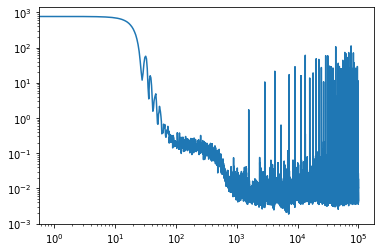

In [29]:
plt.loglog(all_losses)

## Evaluation

In [45]:
test_frames = ase.io.read("data/ethene/coords_ethene_1000.xyz","800:1000")
for f in test_frames:
    f.cell = [100,100,100]
    f.positions += 50
test_focks = np.load("data/ethene/ethene-sto3g-fock-ortho.npy", allow_pickle=True)[800:1000]
  
test_blocks = dense_to_blocks(test_focks, test_frames, orbs)
test_fock_bc = couple_blocks(test_blocks, cg)

In [46]:
test_rhoi = spex.compute(test_frames)
test_gij = pairs.compute(test_frames)
test_rho1i = acdc_standardize_keys(test_rhoi)
test_rho1i = test_rho1i.keys_to_properties(['species_neighbor'])
test_gij =  acdc_standardize_keys(test_gij)
test_rho2i = cg_increment(test_rho1i, test_rho1i, lcut=lmax, other_keys_match=["species_center"], clebsch_gordan=cg)
test_rho1ij = cg_increment(test_rho1i, test_gij, lcut=lmax, other_keys_match=["species_center"], clebsch_gordan=cg)

test_features = hamiltonian_features(test_rho2i, test_rho1ij)

save("test_feature-ethene-sto3g.npz", test_features)

In [47]:
test_feature_path = "./test_feature-ethene-sto3g.npz"
test_data = HamiltonianDataset(test_feature_path, test_blocks, test_focks, test_frames)

In [48]:
test_Sampler = torch.utils.data.sampler.RandomSampler(test_data)
test_BSampler = torch.utils.data.sampler.BatchSampler(test_Sampler, batch_size = len(test_frames), drop_last = False)
test_dataloader = DataLoader(test_data, sampler = test_BSampler, collate_fn = collate_blocks)

In [89]:
test_dataloader.dataset.currentkey = None
for x_data, y_data, structures in test_dataloader:
    t_pred = model(x_data)
    rmse_full = torch.sqrt(mse_full(t_pred, y_data, structures, orbs))
    rmse_eigvals = torch.sqrt(mse_eigvals(t_pred, y_data, structures, orbs))
    print("RMSE_full with LBFGS training in eV is:", rmse_full) 
    print(rmse_eigvals)

RMSE_full with LBFGS training in eV is: tensor(0.0178, grad_fn=<SqrtBackward0>)
tensor(0.0153, grad_fn=<SqrtBackward0>)


### Test for equivariance of the Model

In [68]:
rot_frames = frames.copy()
for i, f in enumerate(rot_frames):
    f.positions = 50+(50-frames[i].positions[:,[2,0,1]])
    f.positions[:,]

In [69]:
rot_rhoi = spex.compute(rot_frames)
rot_gij = pairs.compute(rot_frames)
rot_rho1i = acdc_standardize_keys(rot_rhoi)
rot_rho1i = rot_rho1i.keys_to_properties(['species_neighbor'])
rot_gij =  acdc_standardize_keys(rot_gij)
rot_rho2i = cg_increment(rot_rho1i, rot_rho1i, lcut=lmax, other_keys_match=["species_center"], clebsch_gordan=cg)
rot_rho1ij = cg_increment(rot_rho1i, rot_gij, lcut=lmax, other_keys_match=["species_center"], clebsch_gordan=cg)

In [70]:
rot_features = hamiltonian_features(rot_rho2i, rot_rho1ij)

#from equistore.io import save
save("rot_feature.npz", rot_features)

In [71]:
feature_path = "./rot_feature.npz"
rot_dataset = HamiltonianDataset(feature_path, blocks, focks, frames)

In [80]:
rot_pred = model(rot_features)
rot_pred_fock = blocks_to_dense(rot_pred, rot_frames, orbs)
torch.linalg.eigvalsh(rot_pred_fock[2])

tensor([-0.7622, -0.5788, -0.4673, -0.4172, -0.3533, -0.2686,  0.0197,  0.1209,
         0.1427,  0.1599,  0.2443,  0.3364], grad_fn=<LinalgEighBackward0>)

In [81]:
pred = model(features)
pred_fock = blocks_to_dense(pred, frames, orbs)
torch.linalg.eigvalsh(pred_fock[2])

tensor([-0.7622, -0.5788, -0.4673, -0.4172, -0.3533, -0.2686,  0.0197,  0.1209,
         0.1427,  0.1599,  0.2443,  0.3364], grad_fn=<LinalgEighBackward0>)

In [74]:
np.linalg.eigvalsh(focks[2])

array([-0.75831876, -0.57684645, -0.46718615, -0.41763745, -0.35112173,
       -0.26901738,  0.02139503,  0.12038302,  0.14226228,  0.15995097,
        0.2452729 ,  0.33607859])

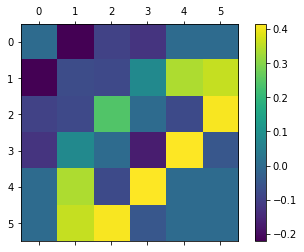

In [59]:
figure = plt.figure()
axes = figure.add_subplot(111)
 
caxes = axes.matshow(rot_pred_fock[0].cpu().detach().numpy()- pred_fock[0].cpu().detach().numpy(), interpolation ='nearest')
figure.colorbar(caxes)
 
plt.show()